In [70]:
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import Word2Vec
from gensim.models import word2vec
from rdkit import Chem
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt

In [37]:
 df = pd.read_csv('/home/mamonteiro/source-code/Project-LEI/SIDER/sider.csv')    

In [38]:
df['smiles'][0:5]

0                                      C(CNCCNCCNCCN)N
1    CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...
2    CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...
3      CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34
4               C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O
Name: smiles, dtype: object

In [39]:
# Get SMILES from file
def getSMILES(filepath):
    df = pd.read_csv(filepath)    
    #smiles = list(df['SMILES or PubChem ID'].dropna())
    smiles_df = df[['smiles']].dropna()
    # some cases have 2 SMILES per compound, which I think are isomers (by looking at the molecular drawings)
    # keeping only the first SMILE string:
    #smiles = [x.split(';')[0] for x in smiles]
    return smiles_df

In [40]:
# Generate molecules from SMILES strings
def generateEmbeddings(smiles_df, trained_model):
    smiles = list(smiles_df['smiles'])
    smiles = [x.split(';')[0] for x in smiles]
    # SMILES to Mol
    molecules = [Chem.MolFromSmiles(x) for x in smiles]
    # Load previously trained mol2vec model
    model = Word2Vec.load(trained_model)
    # Convert molecules to sentences and then to embeddings
    sentences = [mol2alt_sentence(x, 1) for x in molecules]
    vectors = [DfVec(x) for x in sentences2vec(sentences, model, unseen='UNK')]
    vec_df = pd.DataFrame(data=np.array([x.vec for x in vectors]))
    vec_df.columns = ['mol2vec_' + str(x+1) for x in vec_df.columns.values]
    vec_df.index = smiles_df.index.values
    return pd.concat([smiles_df, vec_df], axis=1)

In [41]:
def createDataset(original_data, embeddings_df, output):
    original_df = pd.read_csv(original_data)
    df = original_df.merge(embeddings_df, how='outer', on="smiles")
    df.to_csv(output, index=False)    

In [42]:
simles_from_side =getSMILES('/home/mamonteiro/source-code/Project-LEI/SIDER/sider.csv')
type(simles_from_side)

pandas.core.frame.DataFrame

In [43]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : /home/mamonteiro/source-code/Project-LEI/SIDER
Directory name is : SIDER


In [44]:
emb_df = generateEmbeddings(simles_from_side, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')

In [45]:
emb_df.head()

,smiles,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,C(CNCCNCCNCCN)N,-0.990727,-1.723967,1.596080,0.336589,5.995870,1.602312,-7.893780,-0.770941,2.798226,...,1.845091,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0.596306,0.060384,-4.686247,4.381831,2.139633,-0.343262,-13.849467,0.780369,9.671047,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,1.854099,-4.819261,0.775984,3.286393,1.519570,-6.281527,-10.383826,5.000489,-0.742257,...,0.873612,15.422496,-1.348580,-1.571692,-17.224537,-6.963869,-12.192692,-3.912728,-8.017673,1.265650
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,2.140168,-5.169839,-0.039611,3.000724,0.787211,-6.880911,-10.384640,5.767844,-0.478307,...,0.627151,15.921182,-1.159732,-1.260444,-17.655016,-7.629984,-13.157971,-3.574889,-8.912206,1.509292
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,-0.227203,-2.800524,-1.099674,4.259158,-1.261016,-2.570959,-8.051775,1.025365,6.135835,...,-0.972749,9.117423,7.184863,-0.012285,-7.312431,-1.483516,-4.117091,-2.378627,-9.008883,-0.717169


In [46]:
emb_df.iloc[0][0]

'C(CNCCNCCNCCN)N'

In [47]:
createDataset('/home/mamonteiro/source-code/Project-LEI/SIDER/sider.csv', emb_df, '/home/mamonteiro/source-code/Project-LEI/SIDER/sider_embeddings.csv')

In [48]:
 df = pd.read_csv('/home/mamonteiro/source-code/Project-LEI/SIDER/sider_embeddings.csv')    

In [49]:
df.head()

,smiles,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,C(CNCCNCCNCCN)N,1,1,0,0,1,1,1,0,0,...,1.845092,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0,1,0,0,1,1,1,0,0,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,0,1,0,1,1,0,1,0,1,...,0.873612,15.422496,-1.348580,-1.571692,-17.224537,-6.963869,-12.192692,-3.912728,-8.017673,1.265650
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,1,1,0,1,1,1,1,0,1,...,0.627151,15.921182,-1.159732,-1.260444,-17.655016,-7.629984,-13.157971,-3.574889,-8.912206,1.509292
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,1,1,0,1,1,1,1,0,1,...,-0.972749,9.117423,7.184863,-0.012285,-7.312431,-1.483516,-4.117091,-2.378627,-9.008883,-0.717169



# Multitask Networks On SIDER

In [50]:
import os
import deepchem as dc


current_dir = os.path.dirname(os.path.realpath("__file__"))
dataset_file = "medium_muv.csv.gz"


dataset = dc.utils.save.load_from_disk('/home/mamonteiro/source-code/Project-LEI/SIDER/sider_embeddings.csv')
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

Columns of dataset: ['smiles' 'Hepatobiliary disorders' 'Metabolism and nutrition disorders'
 'Product issues' 'Eye disorders' 'Investigations'
 'Musculoskeletal and connective tissue disorders'
 'Gastrointestinal disorders' 'Social circumstances'
 'Immune system disorders' 'Reproductive system and breast disorders'
 'Neoplasms benign, malignant and unspecified (incl cysts and polyps)'
 'General disorders and administration site conditions'
 'Endocrine disorders' 'Surgical and medical procedures'
 'Vascular disorders' 'Blood and lymphatic system disorders'
 'Skin and subcutaneous tissue disorders'
 'Congenital, familial and genetic disorders'
 'Infections and infestations'
 'Respiratory, thoracic and mediastinal disorders' 'Psychiatric disorders'
 'Renal and urinary disorders'
 'Pregnancy, puerperium and perinatal conditions'
 'Ear and labyrinth disorders' 'Cardiac disorders'
 'Nervous system disorders'
 'Injury, poisoning and procedural complications' 'mol2vec_1' 'mol2vec_2'
 'mol2vec

In [51]:
dataset=dataset.drop(['smiles'], axis=1)

In [52]:
dataset.head(2)

,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,Reproductive system and breast disorders,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,1,1,0,0,1,1,1,0,0,0,...,1.845092,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,0,1,0,0,1,1,1,0,0,1,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869


In [53]:
#sideEfects=
dataset.iloc[:,0:27].head()


,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,Reproductive system and breast disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,1,1,0,0,1,1,1,0,0,0,...,0,0,1,1,0,0,1,1,1,0
1,0,1,0,0,1,1,1,0,0,1,...,0,1,1,0,0,0,1,0,1,0
2,0,1,0,1,1,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0
3,1,1,0,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,1
4,1,1,0,1,1,1,1,0,1,0,...,0,1,1,1,0,0,1,0,1,0


In [54]:
sideEfects= dataset.iloc[:,0:27]

In [55]:
sideEfects.head()

,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,Reproductive system and breast disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,1,1,0,0,1,1,1,0,0,0,...,0,0,1,1,0,0,1,1,1,0
1,0,1,0,0,1,1,1,0,0,1,...,0,1,1,0,0,0,1,0,1,0
2,0,1,0,1,1,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0
3,1,1,0,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,1
4,1,1,0,1,1,1,1,0,1,0,...,0,1,1,1,0,0,1,0,1,0


In [56]:
embeddings=dataset.iloc[:,27:]

In [57]:
embeddings.head()

,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,mol2vec_10,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,-0.990727,-1.723967,1.596080,0.336589,5.995870,1.602312,-7.893780,-0.770941,2.798226,-4.712134,...,1.845092,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,0.596306,0.060384,-4.686247,4.381831,2.139633,-0.343262,-13.849467,0.780369,9.671047,4.445226,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869
2,1.854099,-4.819261,0.775984,3.286393,1.519570,-6.281527,-10.383826,5.000489,-0.742258,0.579260,...,0.873612,15.422496,-1.348580,-1.571692,-17.224537,-6.963869,-12.192692,-3.912728,-8.017673,1.265650
3,2.140168,-5.169839,-0.039611,3.000724,0.787211,-6.880911,-10.384640,5.767844,-0.478307,0.191780,...,0.627151,15.921182,-1.159732,-1.260444,-17.655016,-7.629984,-13.157971,-3.574889,-8.912206,1.509292
4,-0.227203,-2.800524,-1.099673,4.259158,-1.261016,-2.570959,-8.051775,1.025365,6.135835,2.401863,...,-0.972749,9.117423,7.184863,-0.012285,-7.312431,-1.483516,-4.117091,-2.378627,-9.008883,-0.717169


In [58]:
embeddings.isnull().any().any()

False

In [59]:
sideEfects.isnull().any().any()

False

## Scaling and Principal component analysis (PCA)

In [60]:
NCA1 = 100
NCA2 = 100
DROPRATE = 0.2
EP = 500
BATCH_SIZE = 128
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [61]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

In [62]:
X_train, y_train, X_test, y_test = iterative_train_test_split(embeddings.values,
                                                              sideEfects.values, 
                                                              test_size=TEST_RATIO)

In [63]:
X_train, y_train, X_valid, y_valid = iterative_train_test_split(X_train, y_train, 
                                                                test_size=VAL_RATIO)

## Keras Neural Network Model

In [64]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input

In [65]:
sider_model = Sequential()
sider_model.add(Dense(128, input_dim=embeddings.shape[1], 
                      kernel_initializer='he_uniform'))
sider_model.add(BatchNormalization())
sider_model.add(Activation('tanh'))
sider_model.add(Dropout(rate=DROPRATE))
sider_model.add(Dense(64,kernel_initializer='he_uniform'))
sider_model.add(BatchNormalization())
sider_model.add(Activation('tanh'))
sider_model.add(Dropout(rate=DROPRATE))
sider_model.add(Dense(32,kernel_initializer='he_uniform'))
sider_model.add(BatchNormalization())
sider_model.add(Activation('tanh'))
sider_model.add(Dropout(rate=DROPRATE))
sider_model.add(Dense(sideEfects.shape[1],kernel_initializer='he_uniform',activation='sigmoid'))

In [66]:
sider_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [67]:
checkpoint = ModelCheckpoint('sider_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')


In [68]:
hist = sider_model.fit(X_train, y_train, 
                       validation_data=(X_valid,y_valid),epochs=EP, batch_size=BATCH_SIZE, 
                       callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 1125 samples, validate on 151 samples
Epoch 1/500
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7790 - acc: 0.5037 - val_loss: 0.7283 - val_acc: 0.5065

Epoch 00001: val_loss improved from inf to 0.72834, saving model to sider_model.h5
Epoch 2/500
1125/1125 [==============================] - 0s 69us/step - loss: 0.7433 - acc: 0.5211 - val_loss: 0.7074 - val_acc: 0.5372

Epoch 00002: val_loss improved from 0.72834 to 0.70741, saving model to sider_model.h5
Epoch 3/500
1125/1125 [==============================] - 0s 72us/step - loss: 0.7251 - acc: 0.5344 - val_loss: 0.6935 - val_acc: 0.5570

Epoch 00003: val_loss improved from 0.70741 to 0.69347, saving model to sider_model.h5
Epoch 4/500
1125/1125 [==============================] - 0s 67us/step - loss: 0.7116 - acc: 0.5454 - val_loss: 0.6856 - val_acc: 0.5695

Epoch 00004: val_loss improved from 0.69347 to 0.68564, saving model to sider_model.h5
Epoch 5/500
1125/1125 [==============================] - 0s 83

1125/1125 [==============================] - 0s 86us/step - loss: 0.4806 - acc: 0.7739 - val_loss: 0.5358 - val_acc: 0.7346

Epoch 00038: val_loss did not improve from 0.53554
Epoch 39/500
1125/1125 [==============================] - 0s 88us/step - loss: 0.4804 - acc: 0.7729 - val_loss: 0.5337 - val_acc: 0.7361

Epoch 00039: val_loss improved from 0.53554 to 0.53372, saving model to sider_model.h5
Epoch 40/500
1125/1125 [==============================] - 0s 64us/step - loss: 0.4768 - acc: 0.7763 - val_loss: 0.5472 - val_acc: 0.7302

Epoch 00040: val_loss did not improve from 0.53372
Epoch 41/500
1125/1125 [==============================] - 0s 83us/step - loss: 0.4720 - acc: 0.7784 - val_loss: 0.5556 - val_acc: 0.7309

Epoch 00041: val_loss did not improve from 0.53372
Epoch 42/500
1125/1125 [==============================] - 0s 85us/step - loss: 0.4747 - acc: 0.7779 - val_loss: 0.5503 - val_acc: 0.7326

Epoch 00042: val_loss did not improve from 0.53372
Epoch 43/500
1125/1125 [========

1125/1125 [==============================] - 0s 85us/step - loss: 0.4365 - acc: 0.7978 - val_loss: 0.5387 - val_acc: 0.7287

Epoch 00081: val_loss did not improve from 0.52977
Epoch 82/500
1125/1125 [==============================] - 0s 69us/step - loss: 0.4400 - acc: 0.7948 - val_loss: 0.5449 - val_acc: 0.7331

Epoch 00082: val_loss did not improve from 0.52977
Epoch 83/500
1125/1125 [==============================] - 0s 84us/step - loss: 0.4386 - acc: 0.7958 - val_loss: 0.5481 - val_acc: 0.7334

Epoch 00083: val_loss did not improve from 0.52977
Epoch 84/500
1125/1125 [==============================] - 0s 76us/step - loss: 0.4407 - acc: 0.7958 - val_loss: 0.5876 - val_acc: 0.7241

Epoch 00084: val_loss did not improve from 0.52977
Epoch 85/500
1125/1125 [==============================] - 0s 78us/step - loss: 0.4366 - acc: 0.7964 - val_loss: 0.5603 - val_acc: 0.7238

Epoch 00085: val_loss did not improve from 0.52977
Epoch 86/500
1125/1125 [==============================] - 0s 75us/st

1125/1125 [==============================] - 0s 89us/step - loss: 0.4176 - acc: 0.8068 - val_loss: 0.6155 - val_acc: 0.7221

Epoch 00124: val_loss did not improve from 0.52977
Epoch 125/500
1125/1125 [==============================] - 0s 68us/step - loss: 0.4197 - acc: 0.8066 - val_loss: 0.5928 - val_acc: 0.7265

Epoch 00125: val_loss did not improve from 0.52977
Epoch 126/500
1125/1125 [==============================] - 0s 66us/step - loss: 0.4172 - acc: 0.8086 - val_loss: 0.5534 - val_acc: 0.7287

Epoch 00126: val_loss did not improve from 0.52977
Epoch 127/500
1125/1125 [==============================] - 0s 63us/step - loss: 0.4176 - acc: 0.8077 - val_loss: 0.5534 - val_acc: 0.7255

Epoch 00127: val_loss did not improve from 0.52977
Epoch 128/500
1125/1125 [==============================] - 0s 84us/step - loss: 0.4132 - acc: 0.8111 - val_loss: 0.5701 - val_acc: 0.7275

Epoch 00128: val_loss did not improve from 0.52977
Epoch 129/500
1125/1125 [==============================] - 0s 76

1125/1125 [==============================] - 0s 74us/step - loss: 0.3990 - acc: 0.8178 - val_loss: 0.5897 - val_acc: 0.7270

Epoch 00167: val_loss did not improve from 0.52977
Epoch 168/500
1125/1125 [==============================] - 0s 74us/step - loss: 0.3989 - acc: 0.8198 - val_loss: 0.5892 - val_acc: 0.7241

Epoch 00168: val_loss did not improve from 0.52977
Epoch 169/500
1125/1125 [==============================] - 0s 80us/step - loss: 0.4018 - acc: 0.8156 - val_loss: 0.5894 - val_acc: 0.7270

Epoch 00169: val_loss did not improve from 0.52977
Epoch 170/500
1125/1125 [==============================] - 0s 83us/step - loss: 0.3987 - acc: 0.8176 - val_loss: 0.5817 - val_acc: 0.7255

Epoch 00170: val_loss did not improve from 0.52977
Epoch 171/500
1125/1125 [==============================] - 0s 70us/step - loss: 0.3968 - acc: 0.8163 - val_loss: 0.5888 - val_acc: 0.7253

Epoch 00171: val_loss did not improve from 0.52977
Epoch 172/500
1125/1125 [==============================] - 0s 85

1125/1125 [==============================] - 0s 63us/step - loss: 0.3809 - acc: 0.8268 - val_loss: 0.5998 - val_acc: 0.7253

Epoch 00210: val_loss did not improve from 0.52977
Epoch 211/500
1125/1125 [==============================] - 0s 78us/step - loss: 0.3778 - acc: 0.8279 - val_loss: 0.6435 - val_acc: 0.7263

Epoch 00211: val_loss did not improve from 0.52977
Epoch 212/500
1125/1125 [==============================] - 0s 65us/step - loss: 0.3839 - acc: 0.8259 - val_loss: 0.5922 - val_acc: 0.7287

Epoch 00212: val_loss did not improve from 0.52977
Epoch 213/500
1125/1125 [==============================] - 0s 76us/step - loss: 0.3780 - acc: 0.8281 - val_loss: 0.5965 - val_acc: 0.7304

Epoch 00213: val_loss did not improve from 0.52977
Epoch 214/500
1125/1125 [==============================] - 0s 75us/step - loss: 0.3811 - acc: 0.8273 - val_loss: 0.5953 - val_acc: 0.7253

Epoch 00214: val_loss did not improve from 0.52977
Epoch 215/500
1125/1125 [==============================] - 0s 74

1125/1125 [==============================] - 0s 89us/step - loss: 0.3746 - acc: 0.8297 - val_loss: 0.6487 - val_acc: 0.7241

Epoch 00253: val_loss did not improve from 0.52977
Epoch 254/500
1125/1125 [==============================] - 0s 68us/step - loss: 0.3804 - acc: 0.8271 - val_loss: 0.6341 - val_acc: 0.7302

Epoch 00254: val_loss did not improve from 0.52977
Epoch 255/500
1125/1125 [==============================] - 0s 70us/step - loss: 0.3813 - acc: 0.8260 - val_loss: 0.5879 - val_acc: 0.7273

Epoch 00255: val_loss did not improve from 0.52977
Epoch 256/500
1125/1125 [==============================] - 0s 78us/step - loss: 0.3725 - acc: 0.8293 - val_loss: 0.5889 - val_acc: 0.7287

Epoch 00256: val_loss did not improve from 0.52977
Epoch 257/500
1125/1125 [==============================] - 0s 84us/step - loss: 0.3712 - acc: 0.8330 - val_loss: 0.6053 - val_acc: 0.7246

Epoch 00257: val_loss did not improve from 0.52977
Epoch 258/500
1125/1125 [==============================] - 0s 90

1125/1125 [==============================] - 0s 65us/step - loss: 0.3578 - acc: 0.8409 - val_loss: 0.6053 - val_acc: 0.7268

Epoch 00296: val_loss did not improve from 0.52977
Epoch 297/500
1125/1125 [==============================] - 0s 70us/step - loss: 0.3548 - acc: 0.8404 - val_loss: 0.6332 - val_acc: 0.7263

Epoch 00297: val_loss did not improve from 0.52977
Epoch 298/500
1125/1125 [==============================] - 0s 72us/step - loss: 0.3574 - acc: 0.8393 - val_loss: 0.6235 - val_acc: 0.7243

Epoch 00298: val_loss did not improve from 0.52977
Epoch 299/500
1125/1125 [==============================] - 0s 70us/step - loss: 0.3571 - acc: 0.8365 - val_loss: 0.6144 - val_acc: 0.7282

Epoch 00299: val_loss did not improve from 0.52977
Epoch 300/500
1125/1125 [==============================] - 0s 78us/step - loss: 0.3607 - acc: 0.8374 - val_loss: 0.6057 - val_acc: 0.7324

Epoch 00300: val_loss did not improve from 0.52977
Epoch 301/500
1125/1125 [==============================] - 0s 76

1125/1125 [==============================] - 0s 80us/step - loss: 0.3487 - acc: 0.8446 - val_loss: 0.6354 - val_acc: 0.7299

Epoch 00339: val_loss did not improve from 0.52977
Epoch 340/500
1125/1125 [==============================] - 0s 75us/step - loss: 0.3535 - acc: 0.8388 - val_loss: 0.6037 - val_acc: 0.7307

Epoch 00340: val_loss did not improve from 0.52977
Epoch 341/500
1125/1125 [==============================] - 0s 67us/step - loss: 0.3536 - acc: 0.8385 - val_loss: 0.5971 - val_acc: 0.7241

Epoch 00341: val_loss did not improve from 0.52977
Epoch 342/500
1125/1125 [==============================] - 0s 74us/step - loss: 0.3525 - acc: 0.8430 - val_loss: 0.5997 - val_acc: 0.7214

Epoch 00342: val_loss did not improve from 0.52977
Epoch 343/500
1125/1125 [==============================] - 0s 74us/step - loss: 0.3592 - acc: 0.8361 - val_loss: 0.6068 - val_acc: 0.7253

Epoch 00343: val_loss did not improve from 0.52977
Epoch 344/500
1125/1125 [==============================] - 0s 72

1125/1125 [==============================] - 0s 62us/step - loss: 0.3367 - acc: 0.8500 - val_loss: 0.6133 - val_acc: 0.7246

Epoch 00382: val_loss did not improve from 0.52977
Epoch 383/500
1125/1125 [==============================] - 0s 76us/step - loss: 0.3426 - acc: 0.8463 - val_loss: 0.5993 - val_acc: 0.7331

Epoch 00383: val_loss did not improve from 0.52977
Epoch 384/500
1125/1125 [==============================] - 0s 91us/step - loss: 0.3450 - acc: 0.8457 - val_loss: 0.6440 - val_acc: 0.7297

Epoch 00384: val_loss did not improve from 0.52977
Epoch 385/500
1125/1125 [==============================] - 0s 76us/step - loss: 0.3432 - acc: 0.8452 - val_loss: 0.6836 - val_acc: 0.7265

Epoch 00385: val_loss did not improve from 0.52977
Epoch 386/500
1125/1125 [==============================] - 0s 84us/step - loss: 0.3458 - acc: 0.8450 - val_loss: 0.6547 - val_acc: 0.7265

Epoch 00386: val_loss did not improve from 0.52977
Epoch 387/500
1125/1125 [==============================] - 0s 77

1125/1125 [==============================] - 0s 82us/step - loss: 0.3396 - acc: 0.8464 - val_loss: 0.6389 - val_acc: 0.7268

Epoch 00425: val_loss did not improve from 0.52977
Epoch 426/500
1125/1125 [==============================] - 0s 83us/step - loss: 0.3399 - acc: 0.8470 - val_loss: 0.6210 - val_acc: 0.7248

Epoch 00426: val_loss did not improve from 0.52977
Epoch 427/500
1125/1125 [==============================] - 0s 85us/step - loss: 0.3360 - acc: 0.8491 - val_loss: 0.6444 - val_acc: 0.7108

Epoch 00427: val_loss did not improve from 0.52977
Epoch 428/500
1125/1125 [==============================] - 0s 77us/step - loss: 0.3365 - acc: 0.8517 - val_loss: 0.6463 - val_acc: 0.7275

Epoch 00428: val_loss did not improve from 0.52977
Epoch 429/500
1125/1125 [==============================] - 0s 82us/step - loss: 0.3360 - acc: 0.8510 - val_loss: 0.6343 - val_acc: 0.7277

Epoch 00429: val_loss did not improve from 0.52977
Epoch 430/500
1125/1125 [==============================] - 0s 76

1125/1125 [==============================] - 0s 85us/step - loss: 0.3295 - acc: 0.8559 - val_loss: 0.6466 - val_acc: 0.7324

Epoch 00468: val_loss did not improve from 0.52977
Epoch 469/500
1125/1125 [==============================] - 0s 67us/step - loss: 0.3337 - acc: 0.8537 - val_loss: 0.6719 - val_acc: 0.7216

Epoch 00469: val_loss did not improve from 0.52977
Epoch 470/500
1125/1125 [==============================] - 0s 81us/step - loss: 0.3408 - acc: 0.8466 - val_loss: 0.6777 - val_acc: 0.7319

Epoch 00470: val_loss did not improve from 0.52977
Epoch 471/500
1125/1125 [==============================] - 0s 81us/step - loss: 0.3365 - acc: 0.8491 - val_loss: 0.6351 - val_acc: 0.7331

Epoch 00471: val_loss did not improve from 0.52977
Epoch 472/500
1125/1125 [==============================] - 0s 73us/step - loss: 0.3375 - acc: 0.8479 - val_loss: 0.6445 - val_acc: 0.7312

Epoch 00472: val_loss did not improve from 0.52977
Epoch 473/500
1125/1125 [==============================] - 0s 79

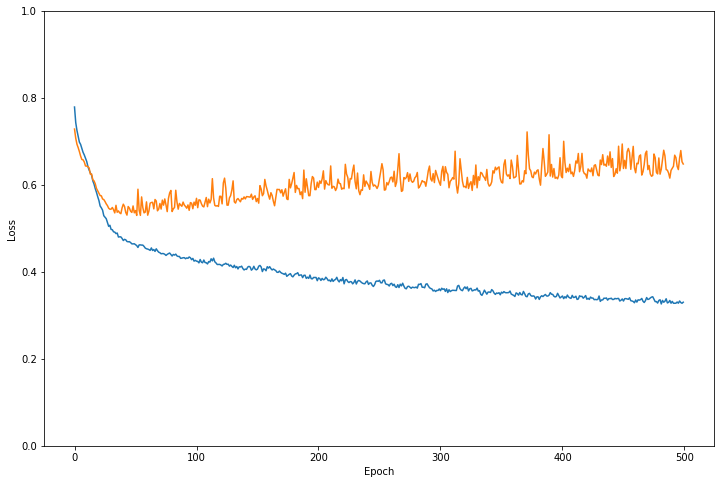

In [75]:
plt.figure(figsize=(12,8))
plt.ylim(0., 1.)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Valid loss")

In [76]:
sider_model.load_weights('sider_model.h5')

In [77]:
pred = sider_model.predict(X_valid)
pred_nn_t = np.copy(pred)

In [78]:
threshold = Find_Optimal_threshold(y_valid, pred)
#print(threshold)

NameError: name 'Find_Optimal_threshold' is not defined